In [1]:
! pip install pandas scikit-learn


Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9210
           1       0.92      0.84      0.88      2046

    accuracy                           0.96     11256
   macro avg       0.94      0.91      0.93     11256
weighted avg       0.96      0.96      0.96     11256


Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2303
           1       0.88      0.71      0.79       511

    accuracy                           0.93      2814
   macro avg       0.91      0.85      0.87      2814
weighted avg       0.93      0.93      0.93      2814

Model metadata logged in ../data/model/model_registry.csv


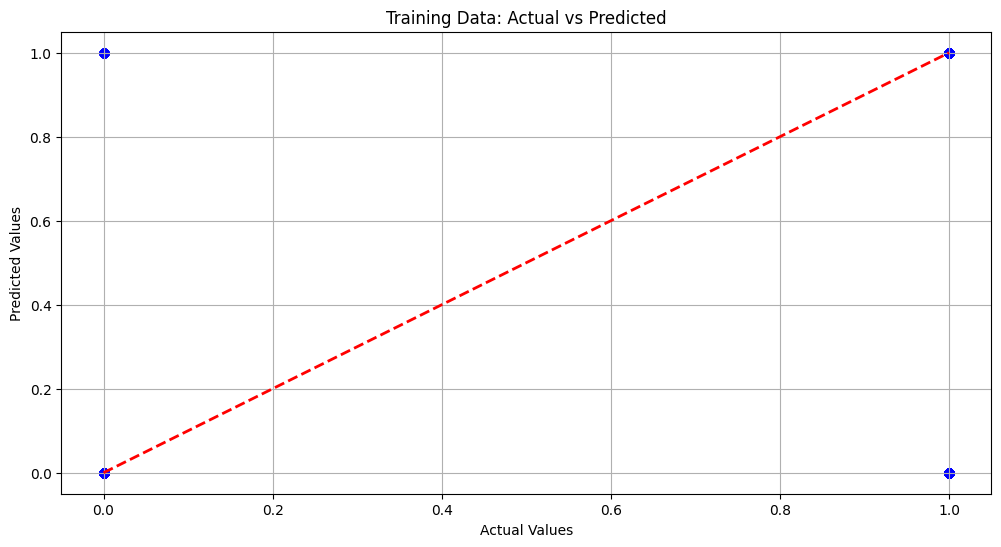

In [ ]:
import pandas as pd
import os
import joblib
import uuid
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

data = pd.read_csv("../data/raw/train_sample_10p.csv")  

target_column = 'Depression' 
X = data.drop(columns=[target_column])  
y = data[target_column]  

numeric_cols = X.select_dtypes(include=['number']).columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns

X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())
for col in non_numeric_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Encode Non-Numeric Columns
X = pd.get_dummies(X, drop_first=True)

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

print("Training Data Classification Report:")
print(classification_report(y_train, y_pred_train))

print("\nTest Data Classification Report:")
print(classification_report(y_test, y_pred_test))

run_id = str(uuid.uuid4())  # Generate a unique ID for this run
run_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Record the current date and time
model_name = "SVM"
model_dir = "../data/model"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, f"svm_model_{run_id}.joblib")
joblib.dump(svm_model, model_path)

feature_columns_path = os.path.join(model_dir, f"feature_columns_{run_id}.joblib")
joblib.dump(X.columns.tolist(), feature_columns_path)

registry_file = os.path.join(model_dir, "model_registry.csv")
if not os.path.exists(registry_file):
    registry_df = pd.DataFrame(columns=["run_date", "model_name", "model_path", "feature_columns_path"])
else:
    registry_df = pd.read_csv(registry_file)

new_entry = {
    "run_date": run_date,
    "model_name": model_name,
    "model_path": model_path,
    "feature_columns_path": feature_columns_path,
}
registry_df = pd.concat([registry_df, pd.DataFrame([new_entry])], ignore_index=True)
registry_df.to_csv(registry_file, index=False)

print(f"Model metadata logged in {registry_file}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, ls='--')
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()
